<h1>Outline<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-to-the-coalescent" data-toc-modified-id="Introduction-to-the-coalescent-1">Introduction to the coalescent</a></span><ul class="toc-item"><li><span><a href="#About" data-toc-modified-id="About-1.1">About</a></span></li><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1.2">Requirements</a></span></li><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1.3">Python setup</a></span></li><li><span><a href="#Backward-and-forward-simulation" data-toc-modified-id="Backward-and-forward-simulation-1.4">Backward and forward simulation</a></span></li><li><span><a href="#The-Wright-Fisher-model" data-toc-modified-id="The-Wright-Fisher-model-1.5">The Wright-Fisher model</a></span></li><li><span><a href="#The-coalescent" data-toc-modified-id="The-coalescent-1.6">The coalescent</a></span></li><li><span><a href="#Statistics-on-tree-branch-lengths" data-toc-modified-id="Statistics-on-tree-branch-lengths-1.7">Statistics on tree branch lengths</a></span></li><li><span><a href="#Adding-mutations" data-toc-modified-id="Adding-mutations-1.8">Adding mutations</a></span></li><li><span><a href="#Some-insights-from-the-simple-coalescent" data-toc-modified-id="Some-insights-from-the-simple-coalescent-1.9">Some insights from the simple coalescent</a></span><ul class="toc-item"><li><span><a href="#Probability-of-a-coalescent-event" data-toc-modified-id="Probability-of-a-coalescent-event-1.9.1">Probability of a coalescent event</a></span></li><li><span><a href="#Time-between-events" data-toc-modified-id="Time-between-events-1.9.2">Time between events</a></span></li><li><span><a href="#Height-of-coalescent-genealogy" data-toc-modified-id="Height-of-coalescent-genealogy-1.9.3">Height of coalescent genealogy</a></span></li><li><span><a href="#Total-tree-length" data-toc-modified-id="Total-tree-length-1.9.4">Total tree length</a></span></li><li><span><a href="#More-sites-better-than-individuals" data-toc-modified-id="More-sites-better-than-individuals-1.9.5">More sites better than individuals</a></span></li></ul></li></ul></li><li><span><a href="#The-coalescent-with-msprime" data-toc-modified-id="The-coalescent-with-msprime-2">The coalescent with msprime</a></span><ul class="toc-item"><li><span><a href="#Simulating-a-genealogy" data-toc-modified-id="Simulating-a-genealogy-2.1">Simulating a genealogy</a></span></li><li><span><a href="#Adding-recombination" data-toc-modified-id="Adding-recombination-2.2">Adding recombination</a></span></li><li><span><a href="#Adding-mutations" data-toc-modified-id="Adding-mutations-2.3">Adding mutations</a></span></li><li><span><a href="#Combining-recombination-and-mutation" data-toc-modified-id="Combining-recombination-and-mutation-2.4">Combining recombination and mutation</a></span></li><li><span><a href="#The-coalescent-with-msprime-and-scikit_allel" data-toc-modified-id="The-coalescent-with-msprime-and-scikit_allel-2.5">The coalescent with msprime and scikit_allel</a></span><ul class="toc-item"><li><span><a href="#Adding-demographic-events" data-toc-modified-id="Adding-demographic-events-2.5.1">Adding demographic events</a></span></li><li><span><a href="#Effect-of-population-size-on-tree" data-toc-modified-id="Effect-of-population-size-on-tree-2.5.2">Effect of population size on tree</a></span></li><li><span><a href="#Effect-of-population-size-on-site-frequency-spectrum" data-toc-modified-id="Effect-of-population-size-on-site-frequency-spectrum-2.5.3">Effect of population size on site frequency spectrum</a></span></li><li><span><a href="#Scikit-allel-and-the-sfs" data-toc-modified-id="Scikit-allel-and-the-sfs-2.5.4">Scikit-allel and the sfs</a></span></li></ul></li></ul></li></ul></div>

# Introduction to the coalescent

## About

This notebook is a compilation of code snippets that I have used for various presentations and lectures. The goal is to present simple python implementations of a forward and backward (aka coalescent) simulator to simulate an evolutionary process.

## Requirements

The examples require that some additional packages be installed. Easiest is probably to create a [conda environment](https://docs.conda.io/en/latest/miniconda.html) as follows:


In [ ]:
!#conda create -n popgen -c conda-forge -c bioconda -c defaults biopython holoviews msprime pandas scikit-allel

## Python setup

Import some libraries and set plotting options for holoviews

In [4]:
import numpy as np
import pandas as pd
import holoviews as hv
import networkx as nx
import random
from io import StringIO
from Bio import Phylo
from holoviews import opts

hv.extension('bokeh')

defaults = dict(width=400, height=1000, padding=0.1)
hv.opts.defaults(
    opts.EdgePaths(**defaults), opts.Graph(**defaults), opts.Nodes(**defaults))

%opts Nodes Graph [width=600 height=600 xaxis=None yaxis=None]
%opts Graph (node_size=8 edge_line_width=1)

random.seed(42)

ModuleNotFoundError: No module named 'holoviews'

## Backward and forward simulation

Basically simulation can be done by following a large population *forward* in time, applying mutation and recombination and selecting individuals to generate offspring as we move forward in time. Alternatively, we can look at a current population and look *backward* in time, keeping track of common ancestry. This has the additional benefit of focusing on the *sample*, which is what we in practice have in our hands, instead of keeping track of the *entire* population. However, with increased computational power, the drawbacks of forward simulation are diminishing.

Hahn, 2019 has compiled a nice list of forward and backwards simulators (Table 6.1).


## The Wright-Fisher model 

The basic Wright-Fisher model is a model of genetic drift in an idealized population where the following assumptions hold:

1. constant size of $N$ diploid individuals (=> $2N$ chromosomes in population)
2. individuals are hermaphrodites (=> random mating)
3. non-overlapping generations
4. chromosomes sampled at random with replacement
5. no individuals survive but are replaced by offspring every generation

The following code snippets show the basics for a simple forward time simulator. Each individual lives in a given generation and is represented by an *index* in that generation. An individual also has an ancestor. It makes sense to think of an individual as a *node* and therefore represent it by a *Node* class.

In [2]:
class Node:
    def __init__(self, node_id = None, anc = None):
        # Unique identifier
        self.id = node_id
        # Ancestor
        self.anc = anc

Furthermore, individuals make up a population, so we define a class to represent a population:

In [3]:
class Population:
    def __init__(self, generation = 0, N = 10, individuals = None):
        self.gen = generation
        if individuals is None:
            self.individuals = np.array([Node(i, Node()) for i in range(N)])
        else:
            self.individuals = individuals
            
    @property
    def imax(self):
        """Return the maximum node id for a populations"""
        return self.individuals[-1].id

We first initialize a population of 10 individuals.

In [4]:
p0 = Population()

Then we add a function to do Wright-Fisher sampling starting from the initial population. The code below returns a list of populations where the indices represent generations.

In [5]:
def WrightFisher(p0, ngen = 10):
    """Do a WrightFisher forward simulation starting at population p0 and run for ngen generations"""
    populations = [p0]
    for t in range(1, ngen):
        parents = populations[t - 1].individuals
        # Sample parent indices
        i = sorted(random.randint(0, len(parents) - 1) for i in range(len(parents)))
        # Generate offspring
        nodeids = range(populations[t - 1].imax + 1, populations[t - 1].imax + len(parents) + 1)
        offspring = np.array([Node(nodeids[j], parents[i[j]]) for j in range(len(parents))])
        # Add population to list
        populations.append(Population(generation=t, individuals=offspring))
    return populations

In [6]:
populations = WrightFisher(p0)

We print the generations and the individuals represented by their unique ids and the parent ids.

In [7]:
t = 0
for p in populations:
    print(t, [(n.id, n.anc.id) for n in p.individuals])
    t = t + 1

0 [(0, None), (1, None), (2, None), (3, None), (4, None), (5, None), (6, None), (7, None), (8, None), (9, None)]
1 [(10, 0), (11, 1), (12, 1), (13, 1), (14, 2), (15, 3), (16, 3), (17, 4), (18, 8), (19, 9)]
2 [(20, 10), (21, 10), (22, 10), (23, 11), (24, 13), (25, 13), (26, 16), (27, 18), (28, 18), (29, 19)]
3 [(30, 20), (31, 22), (32, 23), (33, 23), (34, 24), (35, 26), (36, 26), (37, 27), (38, 28), (39, 29)]
4 [(40, 31), (41, 31), (42, 31), (43, 32), (44, 33), (45, 34), (46, 35), (47, 35), (48, 35), (49, 36)]
5 [(50, 40), (51, 41), (52, 41), (53, 44), (54, 45), (55, 46), (56, 47), (57, 48), (58, 48), (59, 49)]
6 [(60, 50), (61, 51), (62, 51), (63, 53), (64, 53), (65, 54), (66, 54), (67, 55), (68, 59), (69, 59)]
7 [(70, 61), (71, 62), (72, 63), (73, 63), (74, 64), (75, 65), (76, 65), (77, 65), (78, 66), (79, 67)]
8 [(80, 71), (81, 72), (82, 72), (83, 73), (84, 74), (85, 74), (86, 76), (87, 77), (88, 78), (89, 79)]
9 [(90, 80), (91, 80), (92, 81), (93, 83), (94, 83), (95, 84), (96, 85), 

We can also visualize the data to get a clearer view of the process. We use the networkx library to represent nodes and use the holoviews package to make an interactive plot.

In [8]:
nodes = pd.DataFrame({'x': list(range(len(p0.individuals))) * len(populations),
                      'y': list(np.repeat(range(len(populations), 0, -1), len(p0.individuals))),
                      'anc': [n.anc.id for p in populations for n in p.individuals], 
                      'id': [n.id for p in populations for n in p.individuals]})

In [9]:
edges = pd.DataFrame({'starts': [n.anc.id for p in populations[1:] for n in p.individuals],
                      'ends': [n.id for p in populations[1:] for n in p.individuals]})

In [10]:
def plot(nodes, edges):
    nodes_hv = hv.Nodes((nodes['x'], nodes['y'], nodes['id'], nodes['id']))
    return hv.Graph(((edges['starts'], edges['ends']), nodes_hv))

In [11]:
plot(nodes, edges)

:Graph   [start,end]

First, note that we are only simulating parent-offspring relationships, not mutations or recombination.

By looking at chromosomes in the most recent generation, we can see that they share common ancestors. In fact, the sub-trees trace out what we call *genealogies*. Moreover, when going backwards in time two chromosomes merge we say that they *coalesce* into one lineage. Going forward in time, a chromosome would produce two daughter chromosomes. 
It should also be apparent that, beginning with the first generation, most individuals have no descendants at the last generation. One can show that in this simple model by drift alone some 30% of chromosomes are lost each generation due to binomial sampling. 

As a consequence, forward simulations spend a lot of resources simulating data that never makes it to the current generation, and can therefore be very inefficient. If, on the other hand, we would be more efficient if we could focus on the sample in the last generation and work our ways back to common ancestors. This is the essence of coalescent models.


## The coalescent

As with the Wright Fisher model I introduce the coalescent process with written code. It shows how easy it is to simulate genealogies with a coalescent simulator for a constant-sized population. In addition, it is easy to add mutations to a genealogy as they can be modelled by a Poisson process and "sprinkled" on the branches of a genealogy. Note this key feature: creation of genealogy can be separated from the process of adding mutations.

We first write a node class to hold information about ancestors, descendants, coalescence time and number of mutations.

In [1]:
class Node(object):
    def __init__(self, node_id):
        self.id = node_id
        self.time = 0.0
        self.mutations = 0
        self.ancestor = None
        self.left = None
        self.right = None
        
    def __str__(self):
        return "Node {}".format(self.id)

Then we add a Tree class that holds the actual tree nodes as a list and performs the simulations.

In [2]:
class Tree(object):
    def __init__(self, N = 10):
        self.N = N
        # A tree with N leaves has 2N-1 nodes in total
        self.nodes = [Node(i) for i in np.arange(2*N - 1)]
        self.genealogy()
           
    def _set_times(self):
        """Set coalescent times. Start with all individuals and add waiting times as exponential variables
        with rate proportional to 2/(i*(i-1))"""
        t = 0.0
        i = self.N
        while i > 1:
            t += np.random.exponential(2/(i*(i-1)))
            self.nodes[2 * self.N - i].time = t
            i = i - 1
        
    def genealogy(self):
        """Create genealogy. For current time point, select two nodes at random to coalesce, thereby
        creating a new node to choose from in the next time point. Proceed until only one node remains. 
        Note that the actual coalescence times can be set independently."""
        self._set_times() # Set times of coalescent events
        i = self.N
        while i > 1:
            k = 2 * self.N - i  # Ancestor node index for new node
            # Left child index; select from i orphan nodes (subtract 1 due to array indexing)
            j = random.randint(0, i - 1)
            self.nodes[j].ancestor = self.nodes[k]
            self.nodes[k].left = self.nodes[j]
            # Swap j with index i since now we draw from i-1 first nodes
            self._swap(j, i - 1)
            # Right child index; select from i-1 orphan nodes
            j = random.randint(0, i - 2)
            self.nodes[j].ancestor = self.nodes[k]
            self.nodes[k].right = self.nodes[j]
            # Swap j with index k as node k now is an orphan node
            self._swap(j, k)
            i = i - 1
            
    def _swap(self, i, j):
        tmp = self.nodes[i]
        self.nodes[i] = self.nodes[j]
        self.nodes[j] = tmp

We can now generate genealogies. However, we want to visualize them and therefore add a helper function to convert the tree to Newick format:

In [ ]:
def newick(n):
    if isinstance(n, Tree):
        n = n.nodes[0]
    if n.left is not None and n.right is not None:
        if n.ancestor is None:
        # root
            return "({},{}){};".format(newick(n.left), newick(n.right), n.id)
        else:
            return "({},{}):{}".format(newick(n.left), newick(n.right), n.ancestor.time - n.time)
    else:
        # Leaf
        return "{}:{}".format(n.id, n.ancestor.time - n.time)

In [ ]:
tree = Tree(N = 10)
pt = Phylo.read(StringIO(newick(tree)), "newick")
nx = Phylo.to_networkx(pt)
print(Phylo.draw(pt))

Note how the external branches are short, reflecting the higher intensity of the coalescent process, but as we approach the root of the tree, the waiting times get longer and longer (on average).

To summarize, the steps to create a genealogy are (Hahn 2019):

1. start with $i=n$ chromosomes
2. choose a time until the next coalescence from an exponential distribution with parameter x = i(i-1)/2
3. choose two chromosomes at random to coalesce
4. merge the two lineages that were chosen and set i -> i - 1
5. if i>1 go to step 2; if not stop 

Genealogies must be treated in a statistical setting, and cannot be observed directly, but are inferred from patterns of polymorphism, i.e. inference relies on segregating sites (Wakely, 2008). So, we need to model mutations.

## Statistics on tree branch lengths

We are typically interested in statistics based on tree branch lengths, such as the time to the most recent common ancestor, the distribution of branch lengths, or the total length of the tree. Importantly, branch lengths are used to distribute mutations on the tree. Here are three helper functions to calculate these statistics:

In [ ]:
def t_tot(tree):
    return sum((n.ancestor.time - n.time) for n in tree.nodes[1:len(tree.nodes)])
    
def t_mrca(tree):
    return tree.nodes[0].time
    
def t_i(tree):
    return [0.0] + [n.ancestor.time - n.time for n in tree.nodes[1:len(tree.nodes)]]

## Adding mutations

Mutations can be added in two ways (Hahn 2019):

1. Fixed $S$ method: the number of segregating sites is prespecified and distributed on branches in the tree with probability proportional to length of branch
2. Generate mutations using a population mutation parameter $\theta = 4N\mu$. Mutations are modeled as Poisson events with mean $t * \theta /  2$. Typically, first generate total number of mutations $S \sim \mathsf{Po}(\mathsf{T_{total}} * \theta / 2)$ and distribute mutations as in alternative 1.

Here we define a function to add mutations following procedure 2.

In [ ]:
def add_mutations(tree, theta=2.0):
    S = np.random.poisson(t_tot(tree) * theta / 2)
    print("Saw ", S, " mutations")
    # Distribute mutations over branches where branches are sampled with probability proportional to 
    # relative branch length
    Si = np.random.multinomial(S, np.array(t_i(tree)) / sum(t_i(tree)))
    j = -1
    for s in Si:
        j = j + 1
        if s == 0:
            continue
        n = tree.nodes[j]
        print("Adding ", s, " mutations to node ", n.id, " with branch length ", n.ancestor.time - n.time)
        tree.nodes[j].mutations = s
    return tree

In [ ]:
tree = add_mutations(tree)

In [ ]:
[n.mutations for n in tree.nodes]

Increasing theta will increase the number of mutations:

In [ ]:
tree = add_mutations(tree, theta=10)

## Some insights from the simple coalescent

Note: the formulas below may differ depending on source. For instance (Wakeley, 2008) sets the rate of the process to 1, and letting $N \rightarrow \infty$ a factor 2N can be eliminated from the expressions below that are from (Hahn, 2019)

### Probability of a coalescent event

The coalescent is a *model* of a Wright-Fisher population. Time is measured in units of the population size (typically $2N$). An important assumption is that $n << N$ (sample size much smaller than population size). This means only one coalescent event can take in simultaneously, i.e. a coalescent event is modelled as a Poisson process with rate proportional to the number of chromosomes.

Without selection, ancestors are chosen at random. In other words, each chromosome has equal probability $1/2N$ of being a parent. Then, by multiplication of the number of combinations of $i$ samples 

$P(i \rightarrow i - 1) = \frac{i(i-1)}{4N}$


### Time between events

Expected waiting time between two events is approximated by an exponential distribution with mean

$E(T_i) = \frac{4N}{i(i-1)}$

Importantly, this means that the rate decreases with number of chromosomes, and on average the longest waiting time is for the last two chromosomes to coalesce.

### Height of coalescent genealogy

The average tree height is simply the sum of the waiting times $T_i$, $T_{i-1}$, ...:

$E(T_{MCRA}) = 4N\left(1 - \frac{1}{n}\right)$

As $n\rightarrow \infty$, the tree height approaches 4N.

### Total tree length

The sum of all branches in the tree is 

$E(T_{total}) = \sum_{i=2}^n i\frac{4N}{i(i-1)} = 4N \sum_{i=1}^{n-1} \frac{1}{n}$

Of importance: each new chromosome adds less and less to the total length.

### More sites better than individuals


In [ ]:
ns = list(range(2, 101))
df = {'x': ns, 
      'height': [4 * (1 - 1/n) for n in ns],
      'length': [4 * (sum([1/k for k in np.arange(1, n-1)])) for n in ns]}
s1 = hv.Curve((df['x'], df['height']), label = "E[T_total]").opts(color="black")
s2 = hv.Curve((df['x'], df['length']), label = "E[T_MRCA]").opts(color="red")
p1 = hv.Curve((df['x'], [4] * len(ns)))
e = p1 * s1 * s2
e.opts(width=600).redim.label(x="sample size (n)", y = "length in units of N")

# The coalescent with msprime

Until now I have demonstraded how easy it is to perform coalescent simulations with constant population size and without recombination. Adding recombination however results in a much more difficult problem. The genealogies turn into *ancestral recombination graphs* (ARGs) that can diverge as we look back in time. Since we typically want to model more complex scenarios, and for that reason we now use msprime (Kelleher, Etheridge, and McVean 2016). msprime is a python implementation and *much* faster implementation of the seminal ms program (Hudson 2002). We'll start by looking at a simple msprime example, where we add complexity as we go along.

In [5]:
import msprime
from IPython.display import SVG

## Simulating a genealogy

Coalescent simulations create genealogies on which random mutations are sprinkled to introduce sequence variation. To begin with, we show the simplest command for simulating a small sample (n=4) of 10kb sequences from a population with a diploid effective population size 1000 (𝑁𝑒=1000) and printing a genealogy:

In [26]:
tree_sequence = msprime.simulate(sample_size=4, Ne=1000, length=1e4, random_seed=52)
tree = tree_sequence.first()
print(tree.draw(format="unicode"))

    6  
  ┏━┻━┓
  5   ┃
 ┏┻━┓ ┃
 4  ┃ ┃
┏┻┓ ┃ ┃
0 3 2 1



We can also display the tree in svg format as it allows to show the branch lengths and where mutations occur on the tree, and also to draw all tree sequences simultaneously:

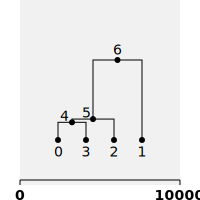

In [27]:
display(SVG(tree_sequence.draw_svg()))

The `tree_sequence` object is a so-called succinct (compact) data structure representation of trees along the sequence, based on the fact that neighbouring genomic regions have correlated genealogical histories. The interested reader can consult the tskit documentation (https://tskit.readthedocs.io/en/latest/data-model.html?highlight=succinct#definitions) for more information. As the name implies, it consists of a sequence of trees, where a tree represents a part of the sequence that has a given genealogy. Since we have no recombination events, there should only be one tree:

In [17]:
len(list(tree_sequence.trees()))

1

## Adding recombination

Recombination events are added via the `recombination_rate` parameter, typically denoted `r` and given as rate per base per generation:

In [6]:
tree_sequence = msprime.simulate(sample_size=4, Ne=1000, length=1e4, random_seed=55, recombination_rate=2e-8)

Now, because of recombination, different parts of the sequence will have different histories, or genealogies. Consequently, we have several trees along the sequence:

In [7]:
len(list(tree_sequence.trees()))

4

where the lengths of the non-recombining segments and the genealogies of the segments can be obtained as follows:

In [8]:
for tree in tree_sequence.trees():
...     print("-" * 20)
...     print("tree {}: interval = {}".format(tree.index, tree.interval))
...     print(tree.draw(format="unicode"))

--------------------
tree 0: interval = (0.0, 1820.1461112639274)
  8    
┏━┻━┓  
┃   7  
┃ ┏━┻┓ 
┃ ┃  5 
┃ ┃ ┏┻┓
0 2 1 3

--------------------
tree 1: interval = (1820.1461112639274, 8028.082481591981)
  8    
┏━┻━┓  
┃   6  
┃ ┏━┻┓ 
┃ ┃  5 
┃ ┃ ┏┻┓
2 0 1 3

--------------------
tree 2: interval = (8028.082481591981, 8866.236572821215)
  9    
┏━┻━┓  
┃   6  
┃ ┏━┻┓ 
┃ ┃  5 
┃ ┃ ┏┻┓
2 0 1 3

--------------------
tree 3: interval = (8866.236572821215, 10000.0)
  9    
┏━┻━┓  
┃   5  
┃ ┏━┻┓ 
┃ ┃  4 
┃ ┃ ┏┻┓
2 1 0 3



Plotted in svg format, we see the tree sequence along the sequence:

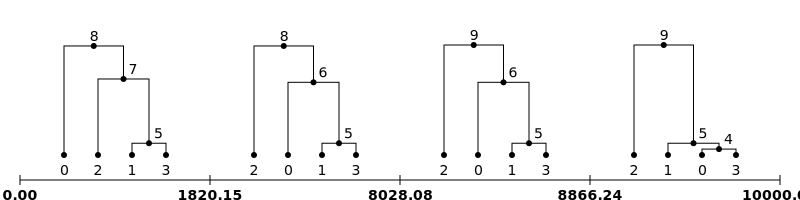

In [9]:
display(SVG(tree_sequence.draw_svg()))

If you study the sequence of trees, you see that they change along the sequence, reflecting the fact that they due to recombination have separate histories. Note also that neighbouring trees are correlated, that is, they have similar topologies. One can transform a tree to a neigbouring tree via simple subtree prune and regraft operations. This observation may seem to indicate that the trees are Markovian, i.e. the state of a tree only depends on its predecessor. That is not strictly true however as there are more long-range correlations. However, this assumption is often made in so-called Sequentially Markovian Coalescent models, on which for instance PSMC and MSMC are based. Also, note that the figure is an example of a sequential visualization of the ARG.

This means that if we could infer genealogies along a sequence, we could also infer the recombination break points. However, as we do not observe genealogies, but rather sequence alignments (of the leaves of the tree), in order to infer genealogies, we need sequence variation, or mutations. Mutations are added by applying the `mutation_rate` parameter, as we will see in the next section.

## Adding mutations

As alluded to previously, in order to actually infer genealogies, we need sequence variation, introduced via mutations. The mutation rate $\mu$, given as a rate per base ber generation, is set via the `mutation_rate` parameter:

In [35]:
tree_sequence = msprime.simulate(sample_size=4, Ne=1000, length=1e4, random_seed=52, mutation_rate=4e-8)
tree = tree_sequence.first()
for site in tree.sites():
    for mutation in site.mutations:
        print("Mutation @ position {:.2f} over node {}".format(site.position, mutation.node))

Mutation @ position 5211.28 over node 1
Mutation @ position 7647.57 over node 5
Mutation @ position 9804.29 over node 1


You may wonder why the positions are not integers. In msprime, mutations are generated under the assumption of the *infinite sites model*, which is why positions are floats, whereas in real life they are integers. This is to prevent a mutation from happening multiple times at one locus.

We can illustrate where the mutations occur by plotting the tree in svg format:

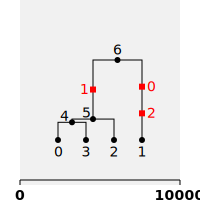

In [36]:
display(SVG(tree_sequence.draw_svg()))

The leaves correspond to sequences that we observe. Here, sequences 0, 3 and 2 will share one mutations (1), whereas sequence 1  has two mutations (0 and 2). We can print the sequences by using the `genotype_matrix` function:

In [37]:
tree_sequence.genotype_matrix()

array([[0, 1, 0, 0],
       [1, 0, 1, 1],
       [0, 1, 0, 0]], dtype=int8)

Here, the rows correspond to sites (mutations) and columns to samples; individual 0 has sequence `010` and so on. Sequence sites are binary coded, where 0 is an ancestral state and 1 is a derived state (mutation).

## Combining recombination and mutation

Typically the data we want consists of both recombination and mutation! Hence, we simply use a combination of the parameters `recombination_rate` and `mutation_rate`:

In [39]:
tree_sequence = msprime.simulate(sample_size=4, Ne=1000, length=1e4, random_seed=55, mutation_rate=4e-8, recombination_rate=2e-8)

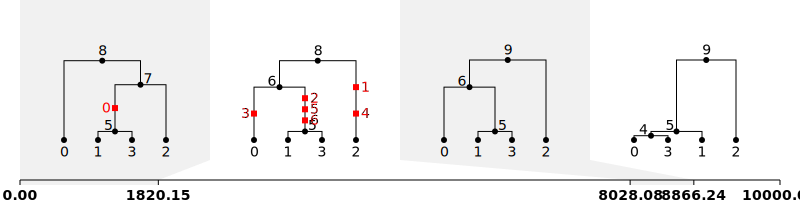

In [40]:
display(SVG(tree_sequence.draw_svg()))

We can print the resulting sequences and compare with the trees to see where mutations occur. For instance, mutation 0 corresponds to the first column in the matrix, and affects individuals 1 and 3.

In [41]:
tree_sequence.genotype_matrix()

array([[0, 1, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 1],
       [0, 1, 0, 1]], dtype=int8)

As an example, individual (leaf) with index 1 has mutations 0, 2, 5, and 6, and its sequence is `1010011`

## The coalescent with msprime and scikit_allel

NB: this section is still WIP!

Sofar we have been looking at a toy example. Here we use msprime to generate more advanced models. The purpose is to illustrate how changes in population size affects the coalescent process. Expected patterns of variation can be more easily understood when interpreted in the coalescent framework.

Lets start by looking at one population in equilibrium with $N_e$ = 100,000 with generation time = 1.

In [42]:
N0 = 100000
ts = msprime.simulate(Ne=N0, sample_size=10)
ts

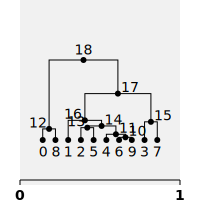

In [43]:
from IPython.display import SVG
SVG(ts.draw_svg())

### Adding demographic events

Demographic events are modelled from the present going backwards in time. Time is measured in units of generations *ago*. The following example models the above population with an expansion taking place 1,000 generations ago.

In [44]:
population_configurations = [
    msprime.PopulationConfiguration(sample_size=10, initial_size=N0)]
demographic_events = [
    msprime.PopulationParametersChange(time=1e3, initial_size=0.1*N0, population_id=0)]

tree_expansion = msprime.simulate(
    random_seed = 42,
    population_configurations = population_configurations,
    demographic_events = demographic_events
)
dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
dd.print_history()


Model =  hudson(reference_size=1)
Epoch: 0 -- 1000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+05    1e+05               0 |     0    

Events @ generation 1000.0
   - Population parameter change for 0: initial_size -> 10000.0 
Epoch: 1000.0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    



### Effect of population size on tree

Here we look at the effect of population expansion vs contraction

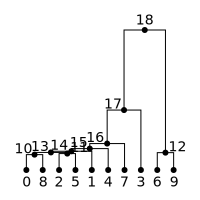

In [45]:
tree_expansion = msprime.simulate(
    random_seed = 42,
    population_configurations = [msprime.PopulationConfiguration(sample_size=10, initial_size=N0)],
    demographic_events = [msprime.PopulationParametersChange(time=1e3, initial_size=0.01*N0, population_id=0)]
)
SVG(tree_expansion.first().draw())

A population expansion leads to longer external branches. Most coalescent events will take place in a short time period centered around the time of expansion. Many mutations will take place on the external branches, leading to an increase in singletons.

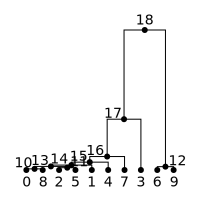

In [46]:
tree_contraction = msprime.simulate(
    random_seed = 42,
    population_configurations = [msprime.PopulationConfiguration(sample_size=10, initial_size=N0)],
    demographic_events = [msprime.PopulationParametersChange(time=1e3, initial_size=100*N0, population_id=0)]
)
SVG(tree_contraction.first().draw())

Now the internal branches are longer.

### Effect of population size on site frequency spectrum

In order to examine the effect of changing population size on the site frequency spectrum (SFS) we need to add mutations. Here we choose $\mu = 1 \times 10^{-8}$ per base per generation in a 1kb sequence.

In [47]:
mu = 1e-8
tree_constant = msprime.simulate(sample_size=10, Ne=N0, mutation_rate=mu, 
                                 random_seed=42, length = 1000)

tree = tree_constant.first()
for site in tree.sites():
    for mutation in site.mutations:
        print("Mutation @ position {:.2f} over node {}".format(
                site.position, mutation.node))


Mutation @ position 65.05 over node 17
Mutation @ position 232.77 over node 15
Mutation @ position 382.46 over node 16
Mutation @ position 466.76 over node 16
Mutation @ position 617.48 over node 3
Mutation @ position 808.40 over node 17
Mutation @ position 948.89 over node 17
Mutation @ position 965.63 over node 17
Mutation @ position 983.23 over node 16


We can also get the variants themselves:

In [ ]:
for variant in tree_constant.variants():
    print(
        variant.site.id, variant.site.position,
        variant.alleles, variant.genotypes, sep="\t")

### Scikit-allel and the sfs

Coming later: we can use scikit.allel to look at the site frequency spectrum...

In [ ]:
import allel
A = tree_constant.genotype_matrix()
A